In [1]:
import os
os.chdir('../')
print(os.listdir())

['.git', '.gitignore', '.idea', 'architecture-design', 'Diplomska-draft.docx', 'docker', 'drive-download-20211215T213754Z-001.zip', 'drive-download-20211221T190522Z-001.zip', 'evaluated-data', 'models', 'notebooks', 'README.md', 'scripts', 'simulated-data-raw', 'spark-warehouse', 'transformed-data', 'venv', '~$plomska-draft.docx', '~WRL4062.tmp']


In [2]:
import pandas as pd

In [3]:
df = pd.read_parquet('transformed-data/training/training_set.parquet', engine='fastparquet')

In [4]:
df

,index,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,...,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,CUSTOMER_ID_NB_TX_1DAY_WINDOW,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_TERMINAL_ID_NB_TX_1DAY_WINDOW,CUSTOMER_ID_TERMINAL_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_TERMINAL_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_MAX_AMOUNT_1DAY_WINDOW,CUSTOMER_ID_MAX_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_MAX_AMOUNT_30DAY_WINDOW
0,1912,1912,2021-09-01 05:35:14,26,6206,80.31,27314,0,0,0,...,80.310000,1,1,1,1,1,1,80.31,80.31,80.31
1,3845,3845,2021-09-01 08:43:42,26,2940,69.57,38622,0,0,0,...,74.940000,2,2,2,1,1,1,80.31,80.31,80.31
2,4612,4612,2021-09-01 09:50:18,26,3021,7.36,42618,0,0,0,...,52.413333,3,3,3,1,1,1,80.31,80.31,80.31
3,17559,17559,2021-09-02 15:18:45,26,9514,36.87,148725,1,0,0,...,48.527500,1,4,4,1,1,1,36.87,80.31,80.31
4,21804,21804,2021-09-03 06:45:13,26,8863,145.33,204313,2,0,0,...,67.888000,2,5,5,1,1,1,145.33,145.33,145.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882482,836402,836402,2021-11-27 07:08:09,4955,4000,32.82,7546089,87,0,0,...,148.550476,3,7,21,1,1,1,83.61,638.85,812.50
882483,865261,865261,2021-11-30 06:54:04,4955,5801,96.36,7804444,90,0,0,...,154.685000,1,7,20,1,1,2,96.36,638.85,812.50
882484,873435,873435,2021-12-01 03:04:45,4955,3858,92.97,7877085,91,0,0,...,151.746190,2,6,21,1,1,1,96.36,96.36,812.50
882485,878497,878497,2021-12-01 12:11:31,4955,7469,106.49,7909891,91,0,0,...,149.689091,2,7,22,1,1,1,106.49,106.49,812.50


In [29]:
# For plotting
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

In [72]:
amount_val = df['TX_AMOUNT'].sample(n=50000).values
customer_max_amounts = df.groupby(['CUSTOMER_ID'])['TX_AMOUNT'].max().reset_index().sort_values(by='TX_AMOUNT', ascending=False).reset_index().head(20)

D:\Anaconda\envs\base2\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 0, 'Customer'), Text(0, 0.5, 'Amount spent')]

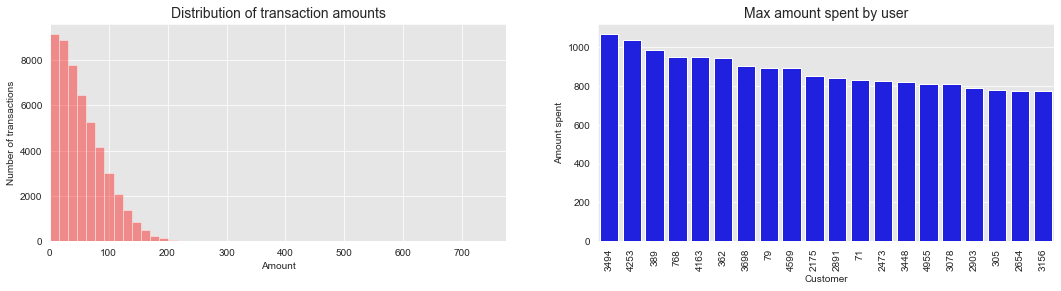

In [91]:
distribution_amount_times_fig, ax = plt.subplots(1, 2, figsize=(18,4))
sns.distplot(amount_val, ax=ax[0], color='r', hist = True, kde = False)
ax[0].set_title('Distribution of transaction amounts', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])
ax[0].set(xlabel = "Amount", ylabel="Number of transactions")

sns.barplot(x='CUSTOMER_ID', y='TX_AMOUNT', data=customer_max_amounts, ax=ax[1], color='blue', order=customer_max_amounts.CUSTOMER_ID)
plt.xticks(rotation=90)
ax[1].set_title('Max amount spent by user', fontsize=14)
# ax[1].set_ylim(0, customer_max_amounts[0][1])
ax[1].set(xlabel='Customer', ylabel='Amount spent')

In [19]:
import datetime
def get_tx_stats(transactions_df, start_date_df="2018-04-01"):
    
    #Number of transactions per day
    nb_tx_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['CUSTOMER_ID'].count()
    #Number of fraudulent transactions per day
    nb_fraudulent_transactions_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['TX_FRAUD'].sum()
    #Number of fraudulent cards per day
    nb_frauded_cards_per_day=transactions_df[transactions_df['TX_FRAUD']==1].groupby(['TX_TIME_DAYS']).CUSTOMER_ID.nunique()
    
    tx_stats=pd.DataFrame({"nb_tx_per_day":nb_tx_per_day,
                           "nb_fraudulent_transactions_per_day":nb_fraudulent_transactions_per_day,
                           "nb_frauded_cards_per_day":nb_frauded_cards_per_day})

    tx_stats=tx_stats.reset_index()
    
    start_date = datetime.datetime.strptime(start_date_df, "%Y-%m-%d")
    tx_date=start_date+tx_stats['TX_TIME_DAYS'].apply(datetime.timedelta)
    
    tx_stats['tx_date']=tx_date
    
    return tx_stats

tx_stats=get_tx_stats(df, start_date_df="2021-09-01")

In [37]:
%%capture

# Plot the number of transactions per day, fraudulent transactions per day and fraudulent cards per day

def get_template_tx_stats(ax ,fs,
                          start_date_training,
                          title='',
                          delta_train=7,
                          delta_delay=7,
                          delta_test=7,
                          ylim=300):
    
    ax.set_title(title, fontsize=fs*1.5)
    ax.set_ylim([0, ylim])
    
    ax.set_xlabel('Date', fontsize=fs)
    ax.set_ylabel('Number', fontsize=fs)
    
    plt.yticks(fontsize=fs*0.7) 
    plt.xticks(fontsize=fs*0.7)    

#     ax.axvline(start_date_training+datetime.timedelta(days=delta_train), 0,ylim, color="black")
#     ax.axvline(start_date_test, 0, ylim, color="black")
    
    ax.text(start_date_training+datetime.timedelta(days=2), ylim-20,'Training period', fontsize=fs)
#     ax.text(start_date_training+datetime.timedelta(days=delta_train+2), ylim-20,'Delay period', fontsize=fs)
#     ax.text(start_date_training+datetime.timedelta(days=delta_train+delta_delay+2), ylim-20,'Test period', fontsize=fs)


cmap = plt.get_cmap('jet')
colors={'nb_tx_per_day':'r', 
        'nb_fraudulent_transactions_per_day':'g', 
        'nb_frauded_cards_per_day':'b'}

fraud_and_transactions_stats_fig, ax = plt.subplots(1, 1, figsize=(15,8))

# Training period
start_date_training = datetime.datetime.strptime("2021-09-01", "%Y-%m-%d")
delta_train = delta_delay = delta_test = 7

end_date_training = start_date_training+datetime.timedelta(days=delta_train-1)

# Test period
# start_date_test = start_date_training+datetime.timedelta(days=delta_train+delta_delay)
# end_date_test = start_date_training+datetime.timedelta(days=delta_train+delta_delay+delta_test-1)

get_template_tx_stats(ax, fs=20,
                      start_date_training=start_date_training,
                      title='Total transactions, and number of fraudulent transactions \n and number of frauded cards per day',
                      delta_train=delta_train,
                      delta_delay=delta_delay,
                      delta_test=delta_test
                     )

ax.plot(tx_stats['tx_date'], tx_stats['nb_tx_per_day']/50, 'b', color=colors['nb_tx_per_day'], label = '# transactions per day (/50)')
ax.plot(tx_stats['tx_date'], tx_stats['nb_fraudulent_transactions_per_day'], 'b', color=colors['nb_fraudulent_transactions_per_day'], label = '# fraudulent txs per day')
ax.plot(tx_stats['tx_date'], tx_stats['nb_frauded_cards_per_day'], 'b', color=colors['nb_frauded_cards_per_day'], label = '# fraudulent cards per day')

ax.legend(loc = 'upper left',bbox_to_anchor=(1.05, 1),fontsize=20)


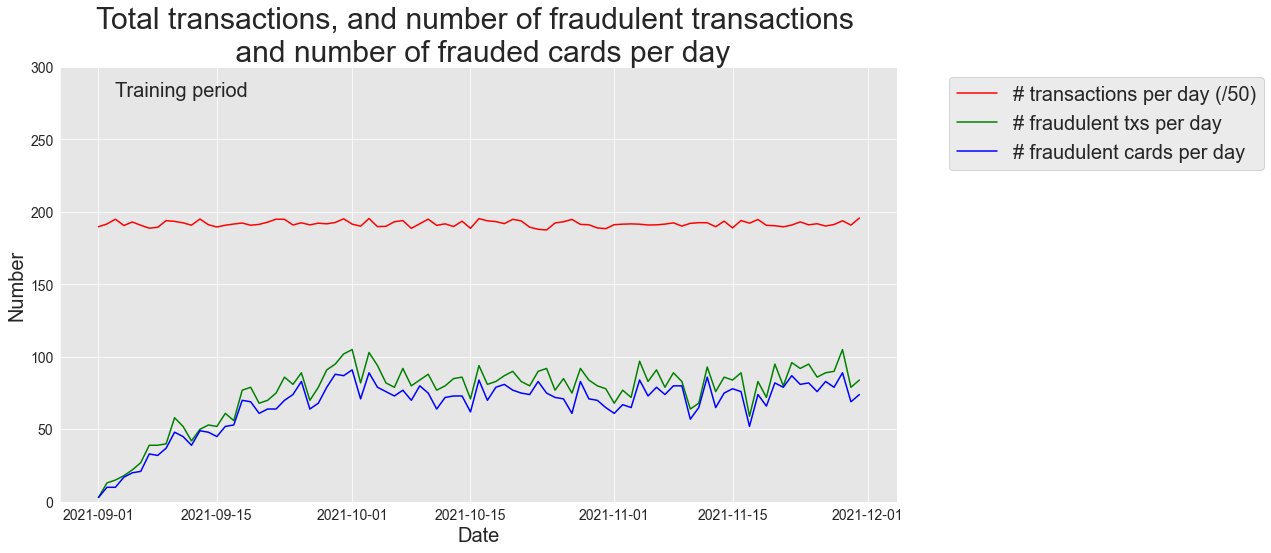

In [38]:
fraud_and_transactions_stats_fig